In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, EfficientNetB0, ResNet101, DenseNet121
import numpy as np
from PIL import Image
import tensorflow as tf
import cv2

# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * tf.math.reduce_sum(y_true * y_pred) + 1.) / (tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred) + 1.)


Возьмем датасет: ADDI project.
Это фотографии двух типов поражений кожи: меланома и родинки. Мы будем их сегментировать.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = './gdrive/MyDrive/SemSegm/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2_Dataset_images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Изменим их размер на  256×256  пикселей и нормализуем изображения в диапазоне  [0,1] .

In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

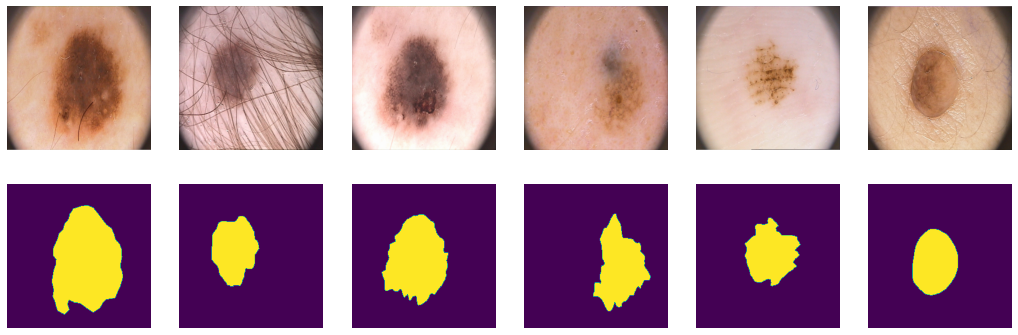

In [7]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50 для обучения, валидации и теста соответственно

In [8]:
N = 100
M = 150
yTrain = Y[:N]
xTrain = X[:N]

yVal = Y[N:M]
xVal = X[N:M]

yTest = Y[M:]
xTest = X[M:]

In [9]:
yTest.shape

(50, 256, 256)

In [10]:
print(xTrain.shape)
print(yTrain.shape)

(100, 256, 256, 3)
(100, 256, 256)


#Создаём и обучаем U-net

In [11]:
from tensorflow.keras.utils import plot_model

**Unet**

In [55]:
def Unet(input_shape= (256, 256, 3)):

  #input_shape= (256, 256, 3) - размер входной картинки

  #model - выходная модель

    img_input = Input(input_shape) # вход модели

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x300

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x150

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x75

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(1, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_51 (BatchN  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 ormalization)                  )                                                           

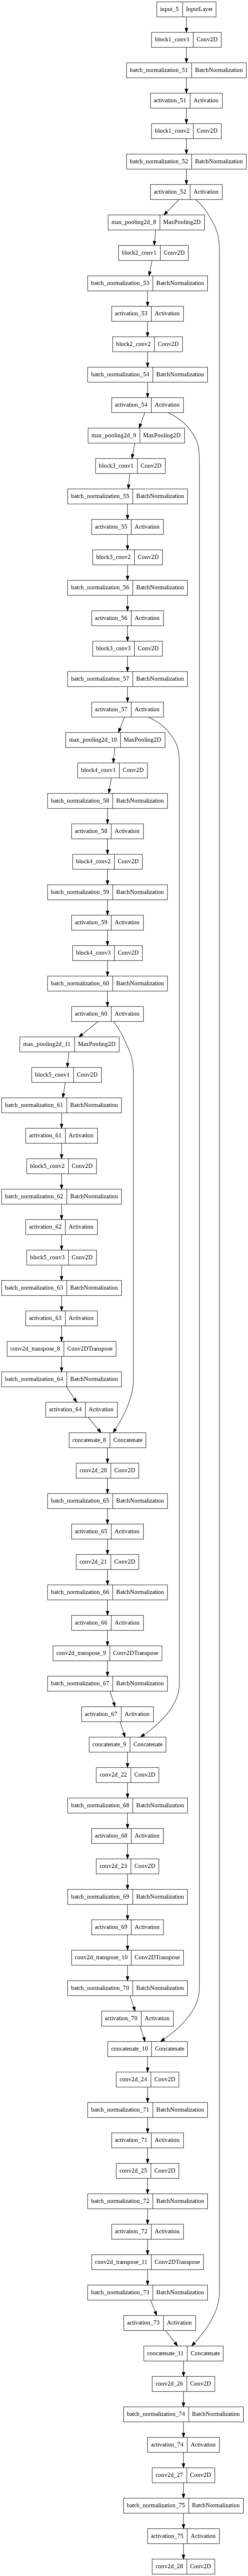

In [56]:
modelC = Unet((256, 256, 3))

plot_model(modelC, to_file='modelC.png')

Обучаем модель

In [57]:
history = modelC.fit(xTrain, yTrain, epochs=5, batch_size=10, validation_data=(xVal, yVal))

Epoch 1/5
10/10 [==============================] - 19s 1s/step - loss: 10.8790 - dice_coef: 0.4404 - val_loss: 11.2480 - val_dice_coef: 0.4102
Epoch 2/5
10/10 [==============================] - 14s 1s/step - loss: 10.8790 - dice_coef: 0.4432 - val_loss: 11.2480 - val_dice_coef: 0.4102
Epoch 3/5
10/10 [==============================] - 14s 1s/step - loss: 10.8790 - dice_coef: 0.4405 - val_loss: 11.2480 - val_dice_coef: 0.4102
Epoch 4/5
10/10 [==============================] - 14s 1s/step - loss: 10.8790 - dice_coef: 0.4414 - val_loss: 11.2480 - val_dice_coef: 0.4102
Epoch 5/5
10/10 [==============================] - 14s 1s/step - loss: 10.8790 - dice_coef: 0.4446 - val_loss: 11.2480 - val_dice_coef: 0.4102


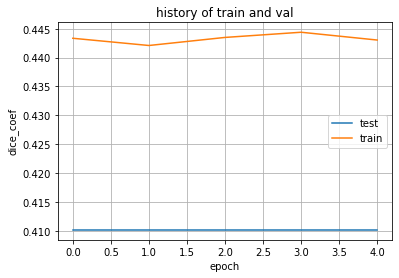

In [15]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.grid()
plt.title('history of train and val')
plt.show()

Тест модели

In [16]:
pred = modelC.predict(xTest)
print(pred.shape)

(50, 256, 256, 1)


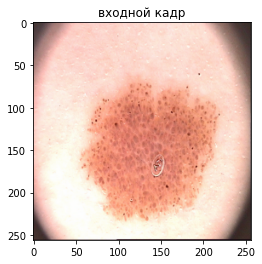

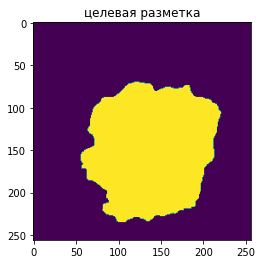

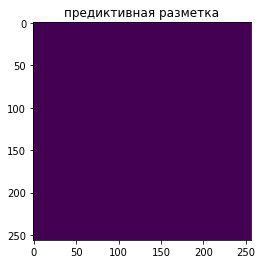

In [58]:
n = 0

plt.imshow(X[N+n])
plt.title('входной кадр')
plt.show()
plt.imshow(Y[N+n])
plt.title('целевая разметка')
plt.show()
img = pred[n].squeeze(-1)
plt.imshow(img.astype(float))
plt.title('предиктивная разметка')
plt.show()

**Претренированная  Unet**

посмотрим на модели для переноса обучения

In [18]:
pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

58900480/58889256 [==============================] - 1s 0us/step


In [19]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

Напишем несколько функций для упрощения сборки модели
  - функцию увеличения разрешения bloc_transpose
  - функцию генерации модели из претернированной unet_pre_train

In [20]:
def bloc_transpose(x,block_out, numb_filter = [256,128]):
  #x, - input tensor
  #block_out, - scip tensor
  #numb_filter = [256,128] - number of kernel in layers
  x = concatenate([x, block_out])
  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 
  x = Conv2DTranspose(numb_filter[1], (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [21]:
pre_trained_model = VGG16(input_shape=(256, 256, 3), include_top=False, weights="imagenet")

def unet_pre_train(num_classes = 1, input_shape= (256, 256, 3), pre_trained_model = None, pretrain_out = 1,list_bloc = [10,6,3]):    
    if pre_trained_model != None:
      for layer in pre_trained_model.layers[:len(pre_trained_model.layers)]:
        layer.trainable = False
      x = pre_trained_model.layers[pretrain_out].output # конец сверток
      block_out = [pre_trained_model.layers[i].output for i in list_bloc]
     
      img_input = pre_trained_model.inputs
      print(block_out[0])
      # первое уменьшение размера
    else:
      return None  
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    # for i,block_i in enumerate(block_out):
    #   x = bloc_transpose(x, block_i, numb_filter = [256// 2**i,128// 2**i])

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization_25 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                                
                                                                 
 activation_25 (Activation)  (None, 256, 256, 64)      0         
                         

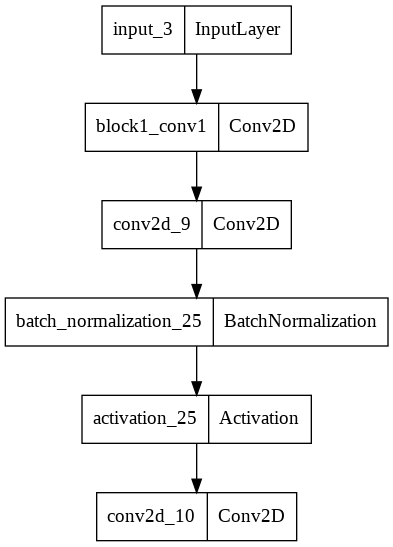

In [22]:
modelU = unet_pre_train(num_classes = 1, input_shape= (256, 256, 3), pre_trained_model = pre_trained_model)

plot_model(modelU, to_file='modelU.png')

In [23]:
from IPython.display import clear_output

Пишем свой обратный вызов. Он только для визуализации результатов работы эпохи

In [24]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = None):
    #clear_output(wait=True)
    Ipred = self.model(xTest[:1])

    k = Ipred.shape[3]
    if k>4:
      k = 4
    print('')
    print('Predict')
    plt.figure(figsize = (5*k,3))
    plt.ylabel('predict')
    for i in range(k):
      plt.subplot(1,k+1,i+1)
      plt.imshow(Ipred[0,:,:,i])
    
    plt.show() 
    print('True') 
    plt.figure(figsize = (5*k,3))
    plt.ylabel('predict')
    for i in range(k):
      plt.subplot(1,k+1,i+1)
      plt.imshow(yTest[0,:,:])
    
    plt.show()

    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 10.8790 - dice_coef: 0.4342
Predict


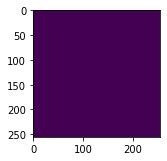

True


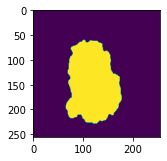


Sample Prediction after epoch 1

34/34 [==============================] - 5s 96ms/step - loss: 10.8790 - dice_coef: 0.4342 - val_loss: 10.8790 - val_dice_coef: 0.4238
Epoch 2/30
33/34 [============================>.] - ETA: 0s - loss: 10.8691 - dice_coef: 0.4347
Predict


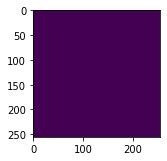

True


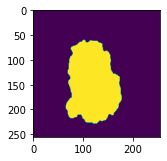


Sample Prediction after epoch 2

34/34 [==============================] - 2s 73ms/step - loss: 10.8790 - dice_coef: 0.4326 - val_loss: 10.8790 - val_dice_coef: 0.4238
Epoch 3/30
33/34 [============================>.] - ETA: 0s - loss: 10.8524 - dice_coef: 0.4322
Predict


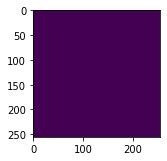

True


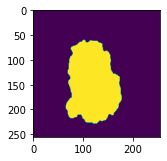


Sample Prediction after epoch 3

34/34 [==============================] - 2s 72ms/step - loss: 10.8790 - dice_coef: 0.4255 - val_loss: 10.8790 - val_dice_coef: 0.4238
Epoch 4/30
33/34 [============================>.] - ETA: 0s - loss: 10.9249 - dice_coef: 0.4301
Predict


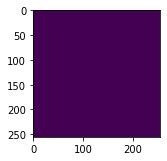

True


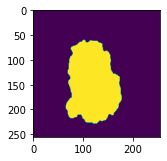


Sample Prediction after epoch 4

34/34 [==============================] - 2s 73ms/step - loss: 10.8790 - dice_coef: 0.4391 - val_loss: 10.8790 - val_dice_coef: 0.4238
Epoch 5/30
33/34 [============================>.] - ETA: 0s - loss: 10.9051 - dice_coef: 0.4342
Predict


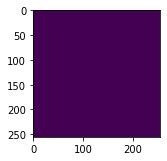

True


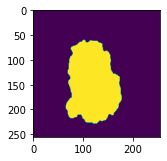


Sample Prediction after epoch 5

34/34 [==============================] - 2s 72ms/step - loss: 10.8790 - dice_coef: 0.4398 - val_loss: 10.8790 - val_dice_coef: 0.4238
Epoch 6/30
33/34 [============================>.] - ETA: 0s - loss: 10.8724 - dice_coef: 0.4326
Predict


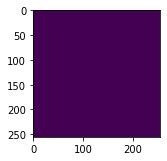

True


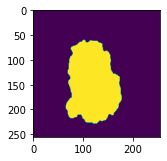


Sample Prediction after epoch 6

34/34 [==============================] - 3s 89ms/step - loss: 10.8790 - dice_coef: 0.4314 - val_loss: 10.8790 - val_dice_coef: 0.4238


In [25]:
tf.debugging.set_log_device_placement(True)
history = modelU.fit(xTrain, yTrain, epochs = 30, batch_size = 3, validation_data = (xTrain, yTrain), callbacks = [tf.keras.callbacks.EarlyStopping(  patience=5 ), DisplayCallback()])

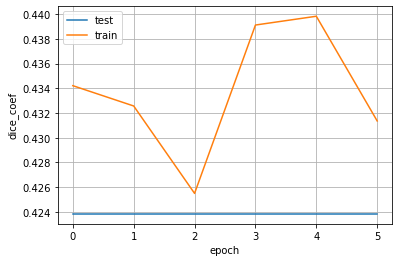

In [26]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.grid()
plt.show()

#Распознаём обучающую выборку

In [27]:
predu = modelU.predict(xTest)
print(predu.shape)


(50, 256, 256, 1)


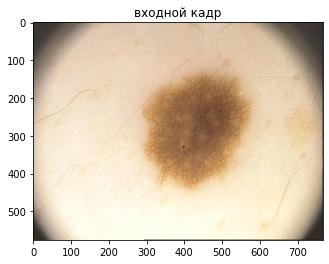

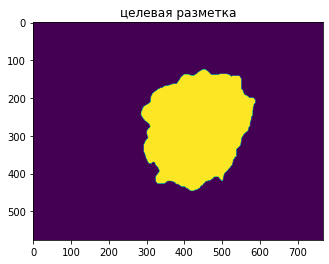

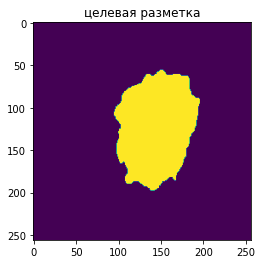

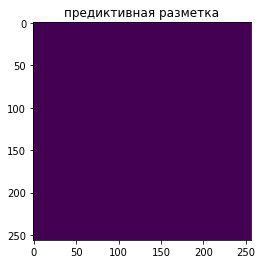

In [42]:
n = 1

plt.imshow(images[M+n])
plt.title('входной кадр')
plt.show()
plt.imshow(lesions[M+n])
plt.title('целевая разметка')
plt.show()
img = yTest[n]
plt.imshow(img.astype(float))
plt.title('целевая разметка')
plt.show()
img = predu[n].squeeze(-1)
plt.imshow(img.astype(float))
plt.title('предиктивная разметка')
plt.show()
